In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

In [2]:
coordinate_airfoil = asb.Airfoil("dae11")
coordinate_airfoil

Airfoil dae11 (81 points)

In [7]:
type(coordinate_airfoil.coordinates)

numpy.ndarray

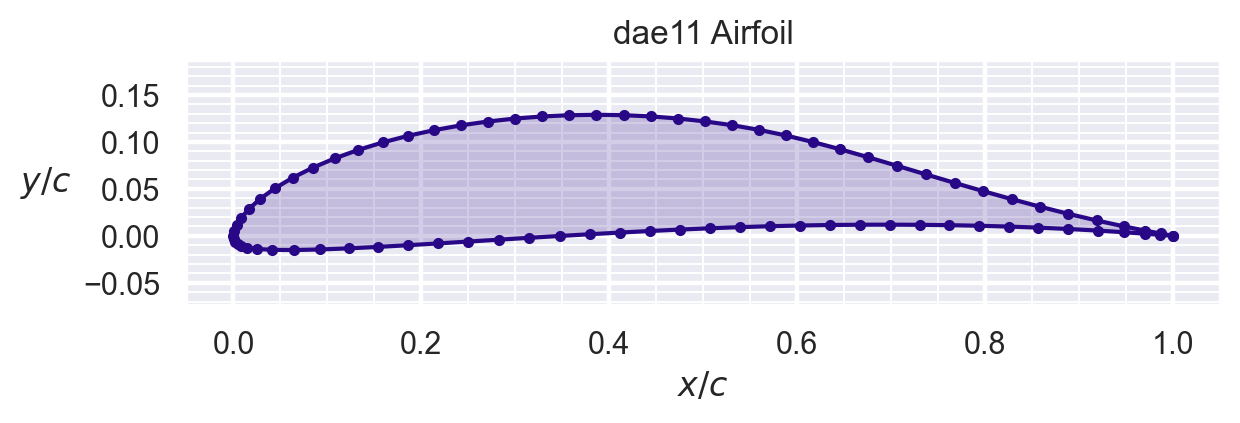

In [8]:
fig, ax = plt.subplots(figsize=(6, 2))
coordinate_airfoil.draw()

In [9]:
kulfan_airfoil = coordinate_airfoil.to_kulfan_airfoil()
kulfan_airfoil

Airfoil dae11 (Kulfan / CST parameterization)

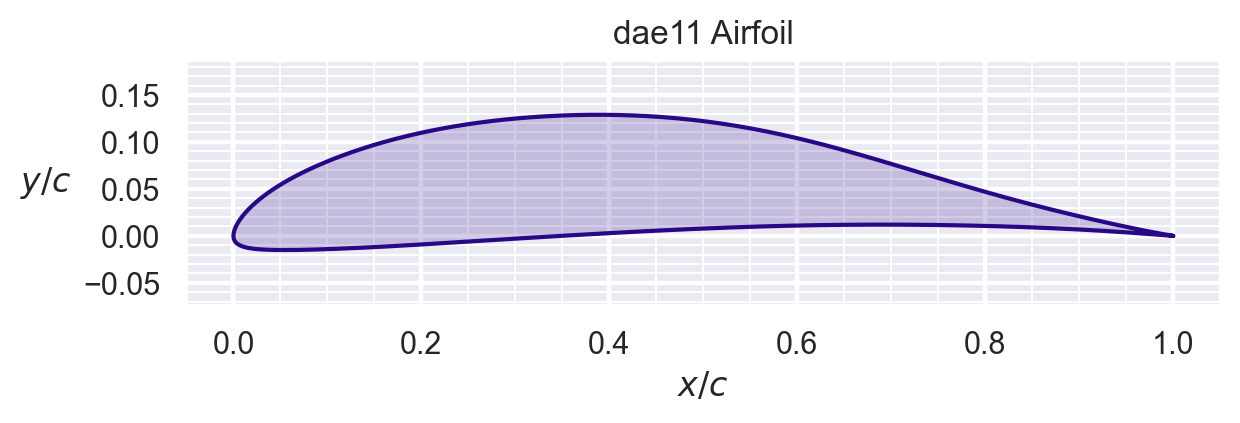

In [10]:
fig, ax = plt.subplots(figsize=(6, 2))
kulfan_airfoil.draw()

In [11]:
from pprint import pprint  # "pretty print"

pprint(kulfan_airfoil.kulfan_parameters)

{'TE_thickness': np.float64(0.00011059192135127555),
 'leading_edge_weight': np.float64(0.5035068867316266),
 'lower_weights': array([-0.16310508, -0.14398528,  0.08896135, -0.0706084 ,  0.09741634,
        0.01466031,  0.07888292,  0.08075122]),
 'upper_weights': array([0.17036014, 0.15272658, 0.51688551, 0.09212467, 0.66904449,
       0.14345864, 0.28990386, 0.16207357])}


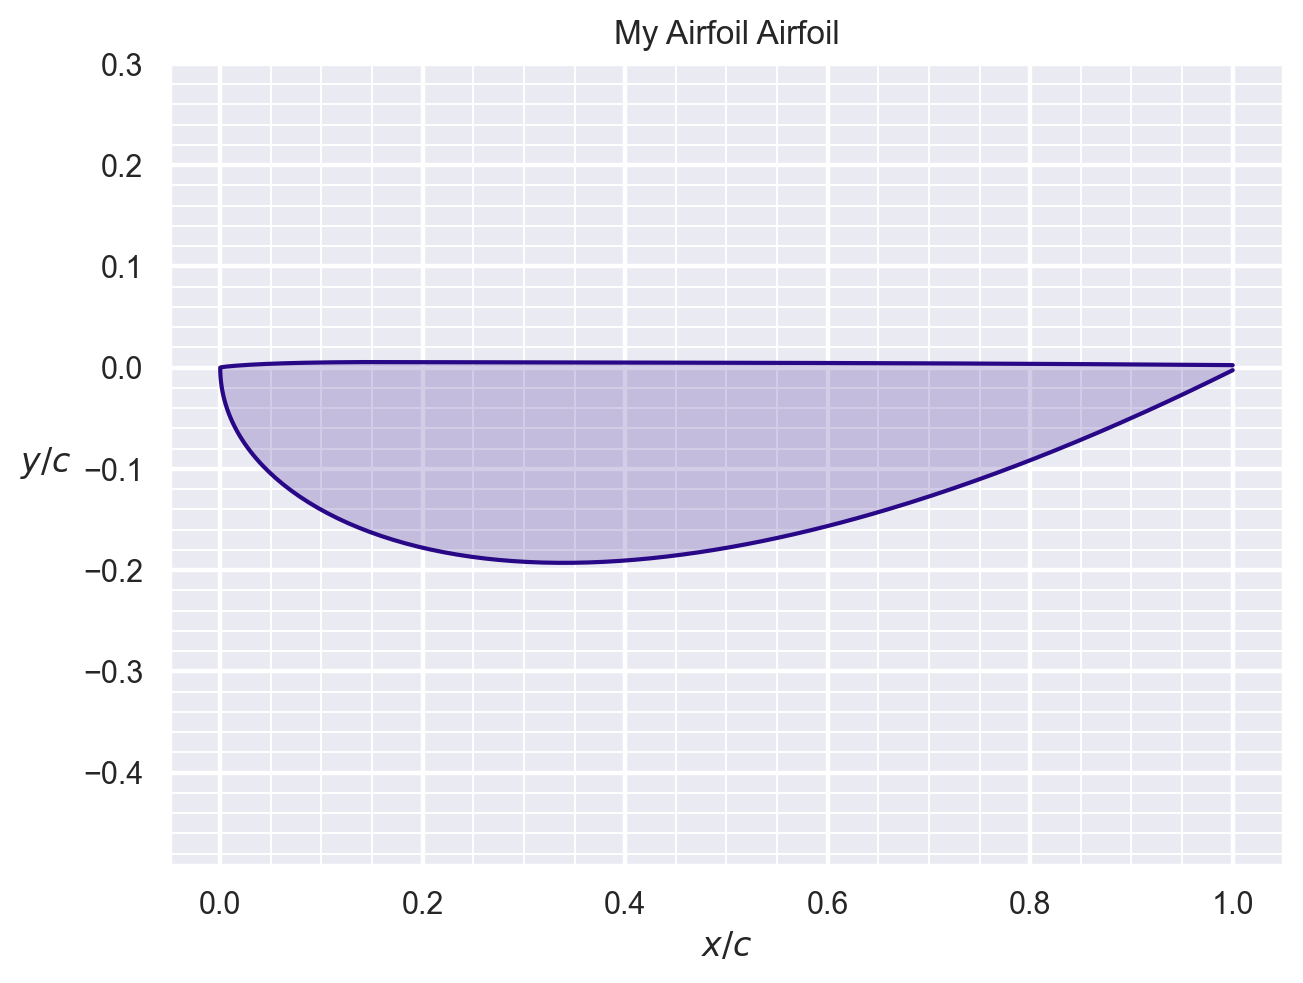

In [20]:
asb.KulfanAirfoil(
    name="My Airfoil",
    lower_weights=-0.5 * np.ones(8),
    upper_weights=0.01 * np.ones(8),
    leading_edge_weight=0.05,
    TE_thickness=0.005,
).draw()

In [55]:
CL_multipoint_targets = np.array([0.8, 1.0, 1.2, 1.4, 1.5, 1.6])
CL_multipoint_weights = np.array([5, 6, 7, 8, 9, 10])
Re = 500e5 * (CL_multipoint_targets / 1.25) ** -0.5
mach = 0.01

In [56]:
initial_guess_airfoil = asb.KulfanAirfoil("naca0012")
initial_guess_airfoil.name = "Initial Guess (NACA0012)"

In [57]:
opti = asb.Opti()

optimized_airfoil = asb.KulfanAirfoil(
    name="Optimized",
    lower_weights=opti.variable(
        init_guess=initial_guess_airfoil.lower_weights,
        lower_bound=-0.5,
        upper_bound=0.25,
    ),
    upper_weights=opti.variable(
        init_guess=initial_guess_airfoil.upper_weights,
        lower_bound=-0.25,
        upper_bound=0.5,
    ),
    leading_edge_weight=opti.variable(
        init_guess=initial_guess_airfoil.leading_edge_weight,
        lower_bound=-1,
        upper_bound=1,
    ),
    TE_thickness=0,
)

alpha = opti.variable(
    init_guess=np.degrees(CL_multipoint_targets / (2 * np.pi)),
    lower_bound=-5,
    upper_bound=18
)

aero = optimized_airfoil.get_aero_from_neuralfoil(
    alpha=alpha,
    Re=Re,
    mach=mach,
)

opti.subject_to([
    aero["analysis_confidence"] > 0.90,
    aero["CL"] == CL_multipoint_targets,
    np.diff(alpha) > 0,
    aero["CM"] >= -0.133,
    optimized_airfoil.local_thickness(x_over_c=0.33) >= 0.128,
    optimized_airfoil.local_thickness(x_over_c=0.90) >= 0.014,
    optimized_airfoil.TE_angle() >= 6.03, # Modified from Drela's 6.25 to match DAE-11 case
    optimized_airfoil.lower_weights[0] < -0.05,
    optimized_airfoil.upper_weights[0] > 0.05,
    optimized_airfoil.local_thickness() > 0
])

get_wiggliness = lambda af: sum([
    np.sum(np.diff(np.diff(array)) ** 2)
    for array in [af.lower_weights, af.upper_weights]
])

opti.subject_to(
    get_wiggliness(optimized_airfoil) < 2 * get_wiggliness(initial_guess_airfoil)
)

opti.minimize(np.mean(aero["CD"] * CL_multipoint_weights))

sol = opti.solve(
    behavior_on_failure="return_last",
    options={
        "ipopt.mu_strategy": 'monotone',
        "ipopt.start_with_resto": 'yes'
    }
)

optimized_airfoil = sol(optimized_airfoil)
aero = sol(aero)


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      108
Number of nonzeros in inequality constraint Jacobian.:     2043
Number of nonzeros in Lagrangian Hessian.............:      261

Total number of variables............................:       23
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:      170
        inequality constraints with only lower bounds:      145
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       25

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.6290807e-02 7.61e-02 1.01e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

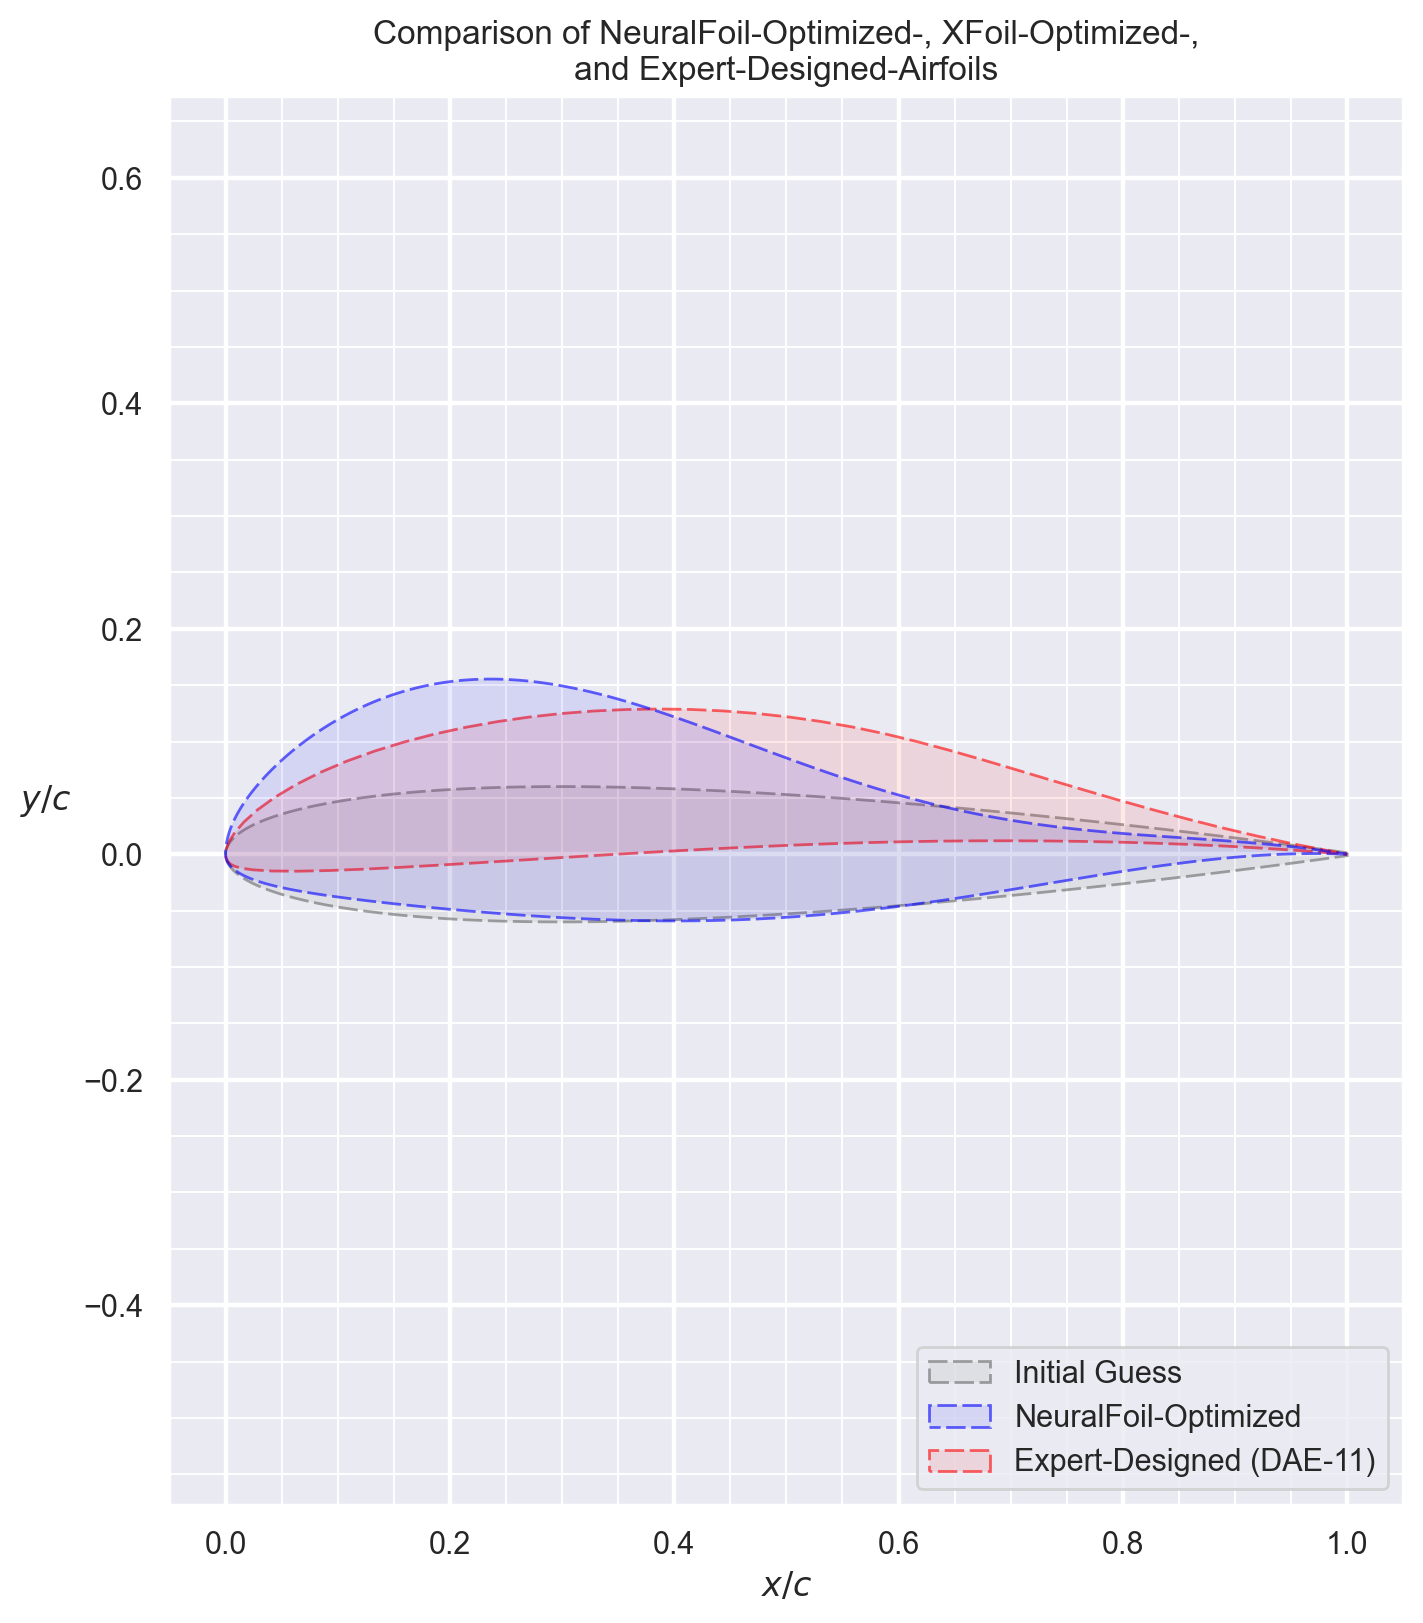

In [58]:
# NBVAL_SKIP

import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

Re_plot = 500e3

fig, ax = plt.subplots(1, 1, figsize=(7, 8))

airfoils_and_colors = {
    "Initial Guess"           : (initial_guess_airfoil, "dimgray"),
    "NeuralFoil-Optimized"    : (optimized_airfoil, "blue"),
    #"XFoil-Optimized"         : (asb.Airfoil(coordinates=f"./assets/drela_opt6_90_dof.dat").to_kulfan_airfoil(), "darkgreen"),
    "Expert-Designed (DAE-11)": (asb.Airfoil("dae11"), "red"),
}

for i, (name, (af, color)) in enumerate(airfoils_and_colors.items()):
    color = p.adjust_lightness(color, 1)
    ax.fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name,
        linestyle=(3 * i, (7, 2)),
        zorder=4 if "NeuralFoil" in name else 3,
    )
    # aero = af.get_aero_from_neuralfoil(
    #     alpha=np.linspace(0, 15, 500),
    #     Re=Re,
    #     mach=mach,
    # )

ax.legend(fontsize=11, loc="lower right", ncol=len(airfoils_and_colors)//2)
ax.set_title("Airfoil Shapes")
ax.set_xlabel("$x/c$")
ax.set_ylabel("$y/c$")
ax.axis('equal')
p.show_plot("Comparison of NeuralFoil-Optimized-, XFoil-Optimized-,\nand Expert-Designed-Airfoils", legend=False)

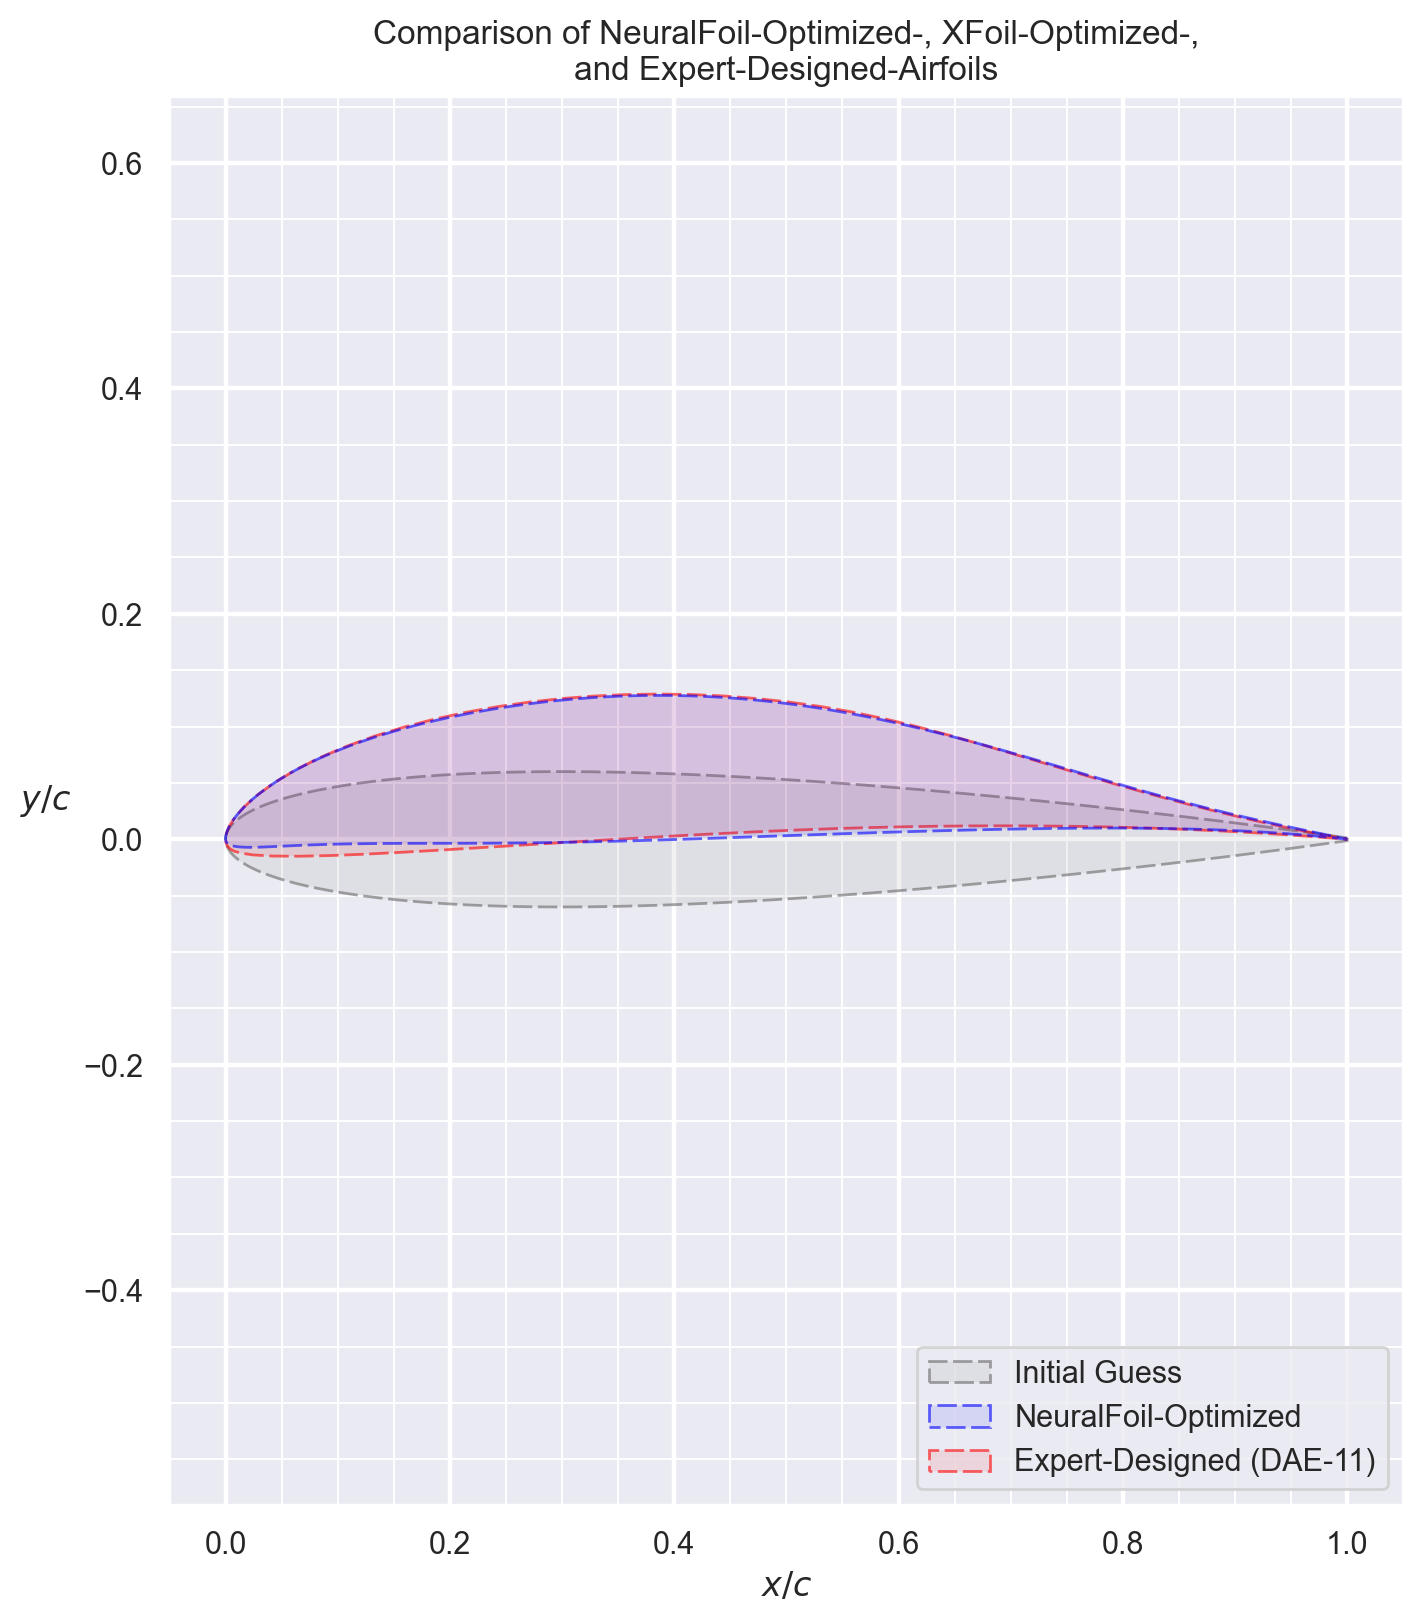

In [32]:
# NBVAL_SKIP

import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

Re_plot = 500e3

fig, ax = plt.subplots(1, 1, figsize=(7, 8))

airfoils_and_colors = {
    "Initial Guess"           : (initial_guess_airfoil, "dimgray"),
    "NeuralFoil-Optimized"    : (optimized_airfoil, "blue"),
    #"XFoil-Optimized"         : (asb.Airfoil(coordinates=f"./assets/drela_opt6_90_dof.dat").to_kulfan_airfoil(), "darkgreen"),
    "Expert-Designed (DAE-11)": (asb.Airfoil("dae11"), "red"),
}

for i, (name, (af, color)) in enumerate(airfoils_and_colors.items()):
    color = p.adjust_lightness(color, 1)
    ax.fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name,
        linestyle=(3 * i, (7, 2)),
        zorder=4 if "NeuralFoil" in name else 3,
    )
    # aero = af.get_aero_from_neuralfoil(
    #     alpha=np.linspace(0, 15, 500),
    #     Re=Re,
    #     mach=mach,
    # )

ax.legend(fontsize=11, loc="lower right", ncol=len(airfoils_and_colors)//2)
ax.set_title("Airfoil Shapes")
ax.set_xlabel("$x/c$")
ax.set_ylabel("$y/c$")
ax.axis('equal')
p.show_plot("Comparison of NeuralFoil-Optimized-, XFoil-Optimized-,\nand Expert-Designed-Airfoils", legend=False)

In [50]:
# Let's define some constants.
opti = asb.Opti()

aspect_ratio = opti.variable(init_guess=10, log_transform=True)  # as an experiment, let's leave this unbounded.
wing_area = opti.variable(init_guess=1, log_transform=True)

span = (aspect_ratio * wing_area) ** 0.5  # Equivalent to saying: AR = b^2 / S
chord = span / aspect_ratio

density = 1e3 # 1.225  # Note: AeroSandbox uses base SI units (or derived units thereof) everywhere, with no exceptions.
viscosity = 1e-3 # 1.81e-5  # So the units here are kg/(m*s).
weight = 20  # 100 N, corresponding to the weight of around 10 kg.
airspeed = 10.
dynamic_pressure = 0.5 * density * airspeed ** 2
lift = weight
CL = lift / dynamic_pressure / wing_area  # Definition of lift coefficient

initial_guess_airfoil = asb.KulfanAirfoil("naca0012")
initial_guess_airfoil.name = "Initial Guess (NACA0012)"

Re = density * airspeed * chord / viscosity  # Definition of Reynolds number
CD_profile = 1.328 * Re ** -0.5  # A rudimentary model of profile drag based on the Blasius solution for flat plate flow.
CD_induced = CL ** 2 / (np.pi * aspect_ratio)  # Textbook equation for induced drag, assuming optimal lift distribution.
CD = CD_profile + CD_induced
drag = dynamic_pressure * wing_area * CD


opti.subject_to([
    CL < 1.2,  # Stall condition
    CL > -1.2  # Stall condition
])

# optimized_airfoil = asb.KulfanAirfoil(
#     name="Optimized",
#     lower_weights=opti.variable(
#         init_guess=initial_guess_airfoil.lower_weights,
#         lower_bound=-0.5,
#         upper_bound=0.25,
#     ),
#     upper_weights=opti.variable(
#         init_guess=initial_guess_airfoil.upper_weights,
#         lower_bound=-0.25,
#         upper_bound=0.5,
#     ),
#     leading_edge_weight=opti.variable(
#         init_guess=initial_guess_airfoil.leading_edge_weight,
#         lower_bound=-1,
#         upper_bound=1,
#     ),
#     TE_thickness=0,
# )

# alpha = opti.variable(
#     init_guess=12, #np.degrees(CL_multipoint_targets / (2 * np.pi)),
#     lower_bound=-5,
#     upper_bound=18,
# )

# aero = optimized_airfoil.get_aero_from_neuralfoil(
#     alpha=alpha,
#     Re=Re,
#     mach=mach,
# )

opti.minimize(drag)

sol = opti.solve()
optimized_airfoil = sol(optimized_airfoil)
aero = sol(aero)
aspect_ratio_opt = sol(aspect_ratio)
wing_area_opt = sol(wing_area)
drag_opt = sol(drag)

print(f"Minimum drag = {drag_opt} N")
print(f"Aspect ratio = {aspect_ratio_opt}")
print(f"Wing area = {wing_area_opt} m^2")


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.7339719e+01 0.00e+00 2.80e+01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

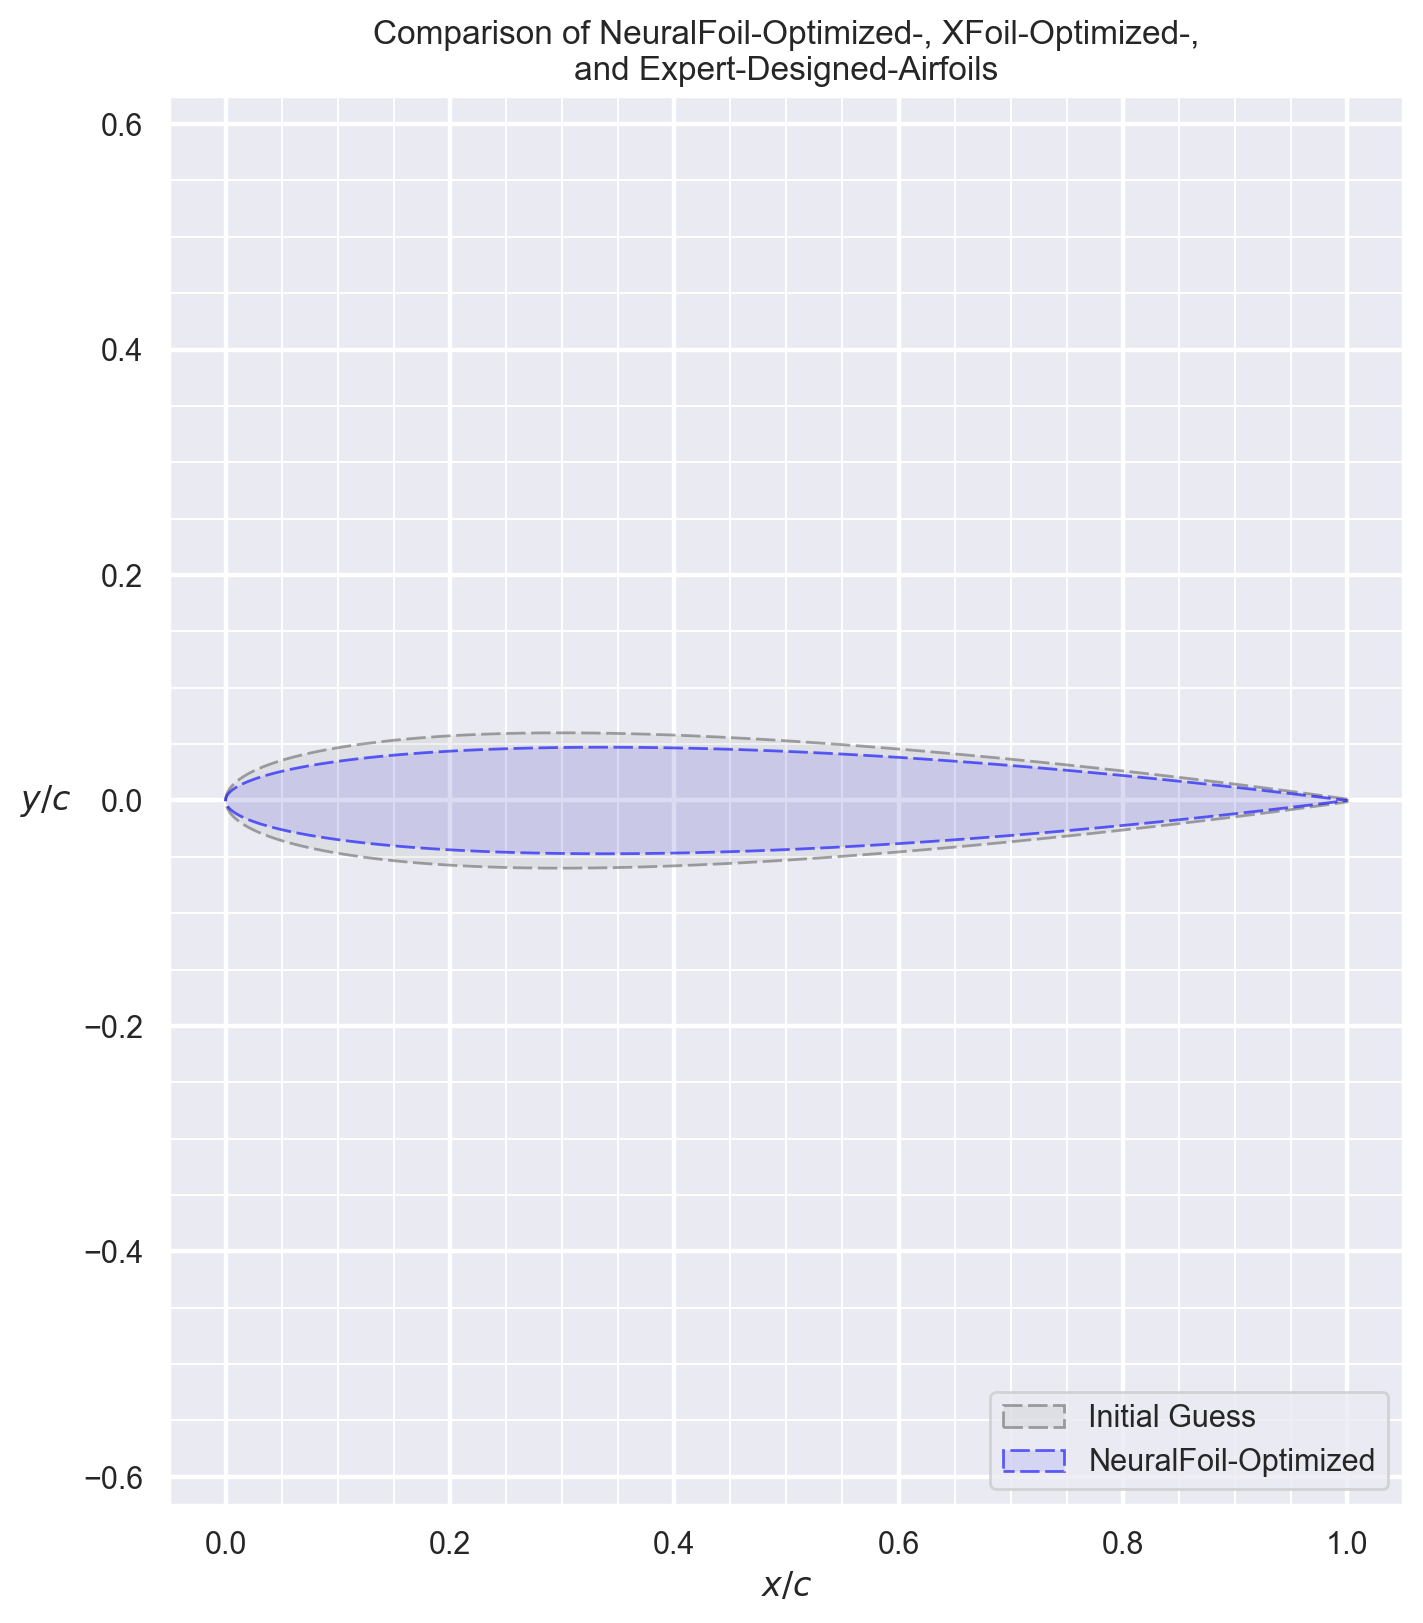

In [48]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

Re_plot = 500e3

fig, ax = plt.subplots(1, 1, figsize=(7, 8))

airfoils_and_colors = {
    "Initial Guess"           : (initial_guess_airfoil, "dimgray"),
    "NeuralFoil-Optimized"    : (optimized_airfoil, "blue"),
    #"XFoil-Optimized"         : (asb.Airfoil(coordinates=f"./assets/drela_opt6_90_dof.dat").to_kulfan_airfoil(), "darkgreen"),
    # "Expert-Designed (DAE-11)": (asb.Airfoil("dae11"), "red"),
}

for i, (name, (af, color)) in enumerate(airfoils_and_colors.items()):
    color = p.adjust_lightness(color, 1)
    ax.fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name,
        linestyle=(3 * i, (7, 2)),
        zorder=4 if "NeuralFoil" in name else 3,
    )
    # aero = af.get_aero_from_neuralfoil(
    #     alpha=np.linspace(0, 15, 500),
    #     Re=Re,
    #     mach=mach,
    # )

ax.legend(fontsize=11, loc="lower right", ncol=len(airfoils_and_colors)//2)
ax.set_title("Airfoil Shapes")
ax.set_xlabel("$x/c$")
ax.set_ylabel("$y/c$")
ax.axis('equal')
p.show_plot("Comparison of NeuralFoil-Optimized-, XFoil-Optimized-,\nand Expert-Designed-Airfoils", legend=False)

In [92]:
# Constants for water
kinematic_viscosity = 1e-6  # m^2/s (for water at ~20°C)
chord_length = 1.0  # assuming unit chord length for normalization

# Define a range of craft speeds [m/s]
speeds = np.linspace(1., 10., 6)
weights = np.ones(len(speeds))  # same weights

Re = (speeds * chord_length) / kinematic_viscosity
mach = 0.01  # stays low

initial_guess_airfoil = asb.KulfanAirfoil("naca0012")
initial_guess_airfoil.name = "Initial Guess (NACA0012)"

opti = asb.Opti()

optimized_airfoil = asb.KulfanAirfoil(
    name="Optimized",
    lower_weights=opti.variable(
        init_guess=initial_guess_airfoil.lower_weights,
        lower_bound=-1.0,
        upper_bound=1.0,
    ),
    upper_weights=opti.variable(
        init_guess=initial_guess_airfoil.upper_weights,
        lower_bound=-1.0,
        upper_bound=1.0,
    ),
    leading_edge_weight=opti.variable(
        init_guess=initial_guess_airfoil.leading_edge_weight,
        lower_bound=-1,
        upper_bound=1,
    ),
    TE_thickness=0.0,
)

alpha = opti.variable(
    init_guess=np.linspace(2, 10, len(speeds)),  # reasonable guesses
    lower_bound=-5,
    upper_bound=18
)

aero = optimized_airfoil.get_aero_from_neuralfoil(
    alpha=alpha,
    Re=Re,
    mach=mach,
)

opti.subject_to([
    aero["analysis_confidence"] > 0.90,
    np.diff(alpha) > 0,
    aero["CM"] >= -0.133,
    optimized_airfoil.local_thickness(x_over_c=0.33) >= 0.128,
    optimized_airfoil.local_thickness(x_over_c=0.90) >= 0.014,
    optimized_airfoil.TE_angle() >= 6.03,
    optimized_airfoil.lower_weights[0] < -0.05,
    optimized_airfoil.upper_weights[0] > 0.05,
    optimized_airfoil.local_thickness() > 0,
])

get_wiggliness = lambda af: sum([
    np.sum(np.diff(np.diff(array)) ** 2)
    for array in [af.lower_weights, af.upper_weights]
])
opti.subject_to(
    get_wiggliness(optimized_airfoil) < 2 * get_wiggliness(initial_guess_airfoil)
)

# L/D = CL / CD --> minimize CD / CL (weighted)
opti.minimize(np.mean((aero["CD"] / aero["CL"]) * weights))

sol = opti.solve(
    behavior_on_failure="return_last",
    options={
        "ipopt.mu_strategy": 'monotone',
        "ipopt.start_with_resto": 'yes'
    }
)

optimized_airfoil = sol(optimized_airfoil)
aero = sol(aero)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     2043
Number of nonzeros in Lagrangian Hessian.............:      261

Total number of variables............................:       23
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      170
        inequality constraints with only lower bounds:      145
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       25

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4021381e-02 9.19e-03 9.96e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

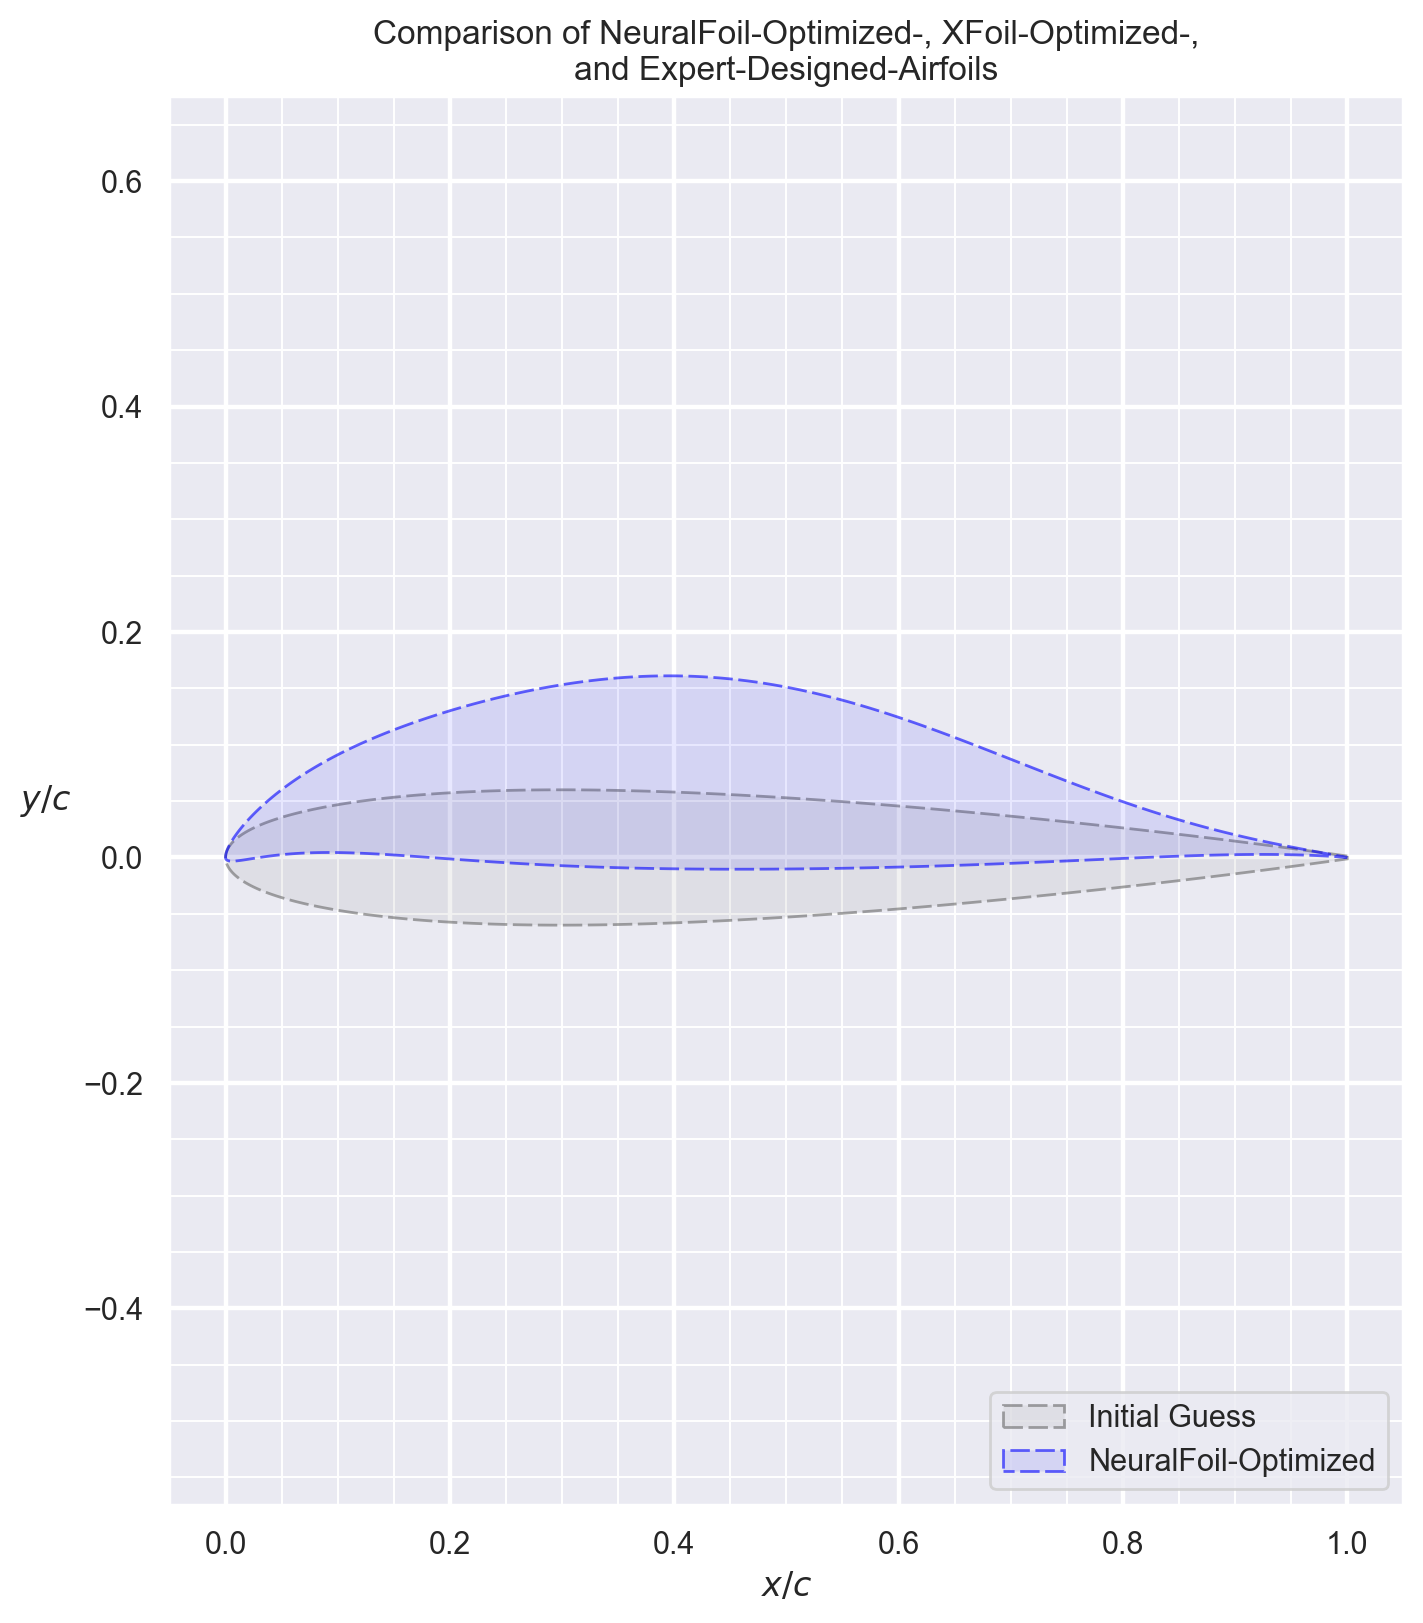

In [93]:
# NBVAL_SKIP

import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

fig, ax = plt.subplots(1, 1, figsize=(7, 8))

airfoils_and_colors = {
    "Initial Guess"           : (initial_guess_airfoil, "dimgray"),
    "NeuralFoil-Optimized"    : (optimized_airfoil, "blue"),
    #"XFoil-Optimized"         : (asb.Airfoil(coordinates=f"./assets/drela_opt6_90_dof.dat").to_kulfan_airfoil(), "darkgreen"),
    #"Expert-Designed (DAE-11)": (asb.Airfoil("dae11"), "red"),
}

for i, (name, (af, color)) in enumerate(airfoils_and_colors.items()):
    color = p.adjust_lightness(color, 1)
    ax.fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name,
        linestyle=(3 * i, (7, 2)),
        zorder=4 if "NeuralFoil" in name else 3,
    )
    # aero = af.get_aero_from_neuralfoil(
    #     alpha=np.linspace(0, 15, 500),
    #     Re=Re,
    #     mach=mach,
    # )

ax.legend(fontsize=11, loc="lower right", ncol=len(airfoils_and_colors)//2)
ax.set_title("Airfoil Shapes")
ax.set_xlabel("$x/c$")
ax.set_ylabel("$y/c$")
ax.axis('equal')
p.show_plot("Comparison of NeuralFoil-Optimized-, XFoil-Optimized-,\nand Expert-Designed-Airfoils", legend=False)

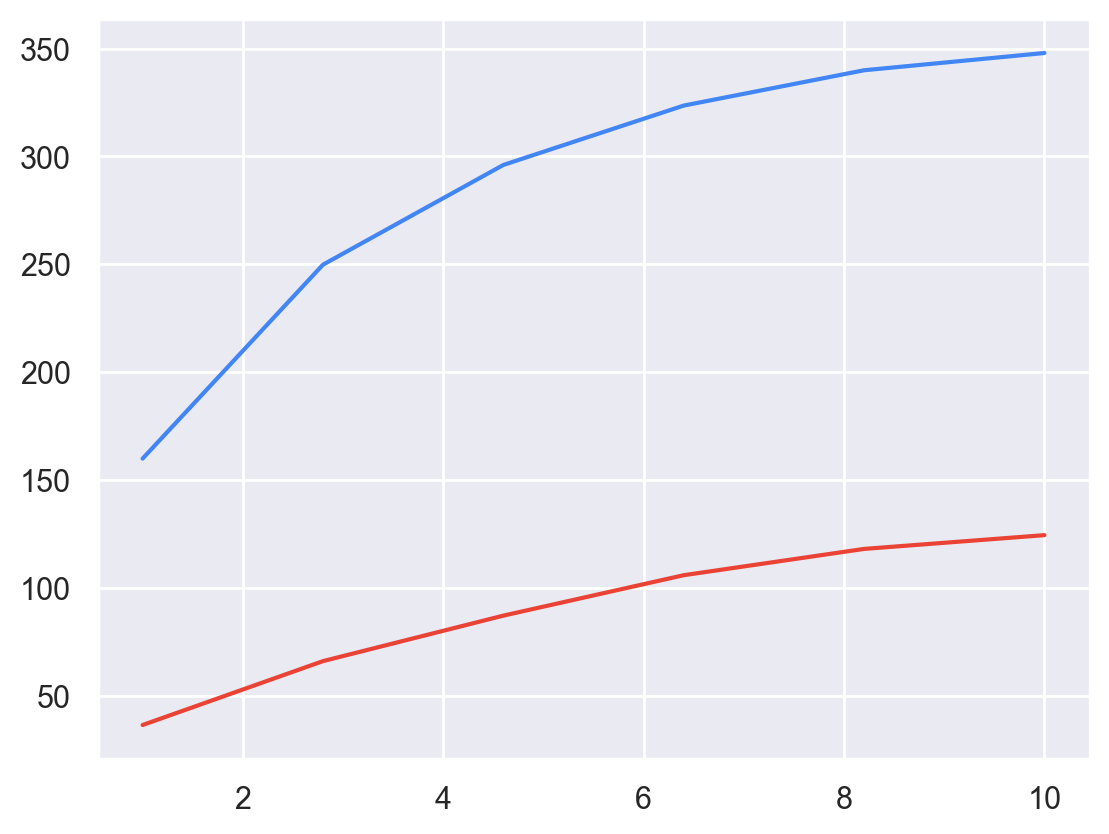

In [94]:
plt.plot(speeds, aero["CL"] / aero["CD"])
initial_aero = initial_guess_airfoil.get_aero_from_neuralfoil(
    alpha=np.linspace(2, 10, len(speeds)),
    Re=Re,
    mach=mach,
)
plt.plot(speeds, initial_aero["CL"] / initial_aero["CD"], label="Initial Guess")

In [103]:
import aerosandbox as asb
import numpy as np

# --- FLUID + SPEEDS ---
kinematic_viscosity = 1e-6  # m^2/s (water at ~20°C)
speed_range = np.linspace(1., 10., 6)
weights = np.ones(len(speed_range))

Re = (speed_range * 1.0) / kinematic_viscosity  # Assuming unit chord
mach = 0.01

# --- OPTIMIZER ---
opti = asb.Opti()

# --- BASE AIRFOIL ---
initial_airfoil = asb.KulfanAirfoil("naca0012")

# --- SPANWISE TWIST & AIRFOIL PARAMS ---
num_spanwise_sections = 5
span = 2.0
twist = opti.variable(
    init_guess=np.linspace(5, 0, num_spanwise_sections),
    lower_bound=-5,
    upper_bound=15,
)

# Spanwise airfoils
airfoils = [
    asb.KulfanAirfoil(
        name=f"section_{i}",
        lower_weights=opti.variable(
            init_guess=initial_airfoil.lower_weights,
            lower_bound=-1,
            upper_bound=1,
        ),
        upper_weights=opti.variable(
            init_guess=initial_airfoil.upper_weights,
            lower_bound=-1,
            upper_bound=1,
        ),
        leading_edge_weight=opti.variable(
            init_guess=initial_airfoil.leading_edge_weight,
            lower_bound=-1,
            upper_bound=1,
        ),
        TE_thickness=0.0,
    )
    for i in range(num_spanwise_sections)
]

# --- DEFINE 3D WING ---
wing = asb.Wing(
    name="OptimizedWing",
    xsecs=[
        asb.WingXSec(
            x_le=0,
            y_le=span * y,
            z_le=0,
            chord=1.0,
            twist=twist[i],
            airfoil=airfoils[i],
        )
        for i, y in enumerate(np.linspace(-0.5, 0.5, num_spanwise_sections))
    ],
    symmetric=True,
)

# --- DEFINE AIRPLANE ---
airplane = asb.Airplane(
    name="OptimizedAircraft",
    wings=[wing],
)

# --- AERO SOLVER ---
alpha = opti.variable(
    init_guess=np.linspace(2, 10, len(speed_range)),
    lower_bound=-5,
    upper_bound=18,
)

# --- OPERATING CONDITIONS ---
op_point = asb.OperatingPoint(
    velocity=10.,  # Example velocity in m/s
    alpha=5.,      # Example angle of attack in degrees
    beta=0,       # Sideslip angle in degrees
    p=0,          # Roll rate in rad/s
    q=0,          # Pitch rate in rad/s
    r=0,          # Yaw rate in rad/s
)

# --- LIFTING LINE ANALYSIS ---
lifting_line = asb.LiftingLine(
    airplane=airplane,
    op_point=op_point,
)

aero = lifting_line.run()

# --- CONSTRAINTS ---
# opti.subject_to([
    # aero["analysis_confidence"] > 0.90,
    # np.diff(alpha) > 0,
    # aero["CM"] >= -0.133,
# ])

# Airfoil thickness constraints (for just root section — generalize if needed)
# root_af = airfoils[num_spanwise_sections // 2]
# opti.subject_to([
#     root_af.local_thickness(x_over_c=0.33) >= 0.128,
#     root_af.local_thickness(x_over_c=0.90) >= 0.014,
#     root_af.TE_angle() >= 6.03,
#     root_af.lower_weights[0] < -0.05,
#     root_af.upper_weights[0] > 0.05,
#     root_af.local_thickness() > 0,
# ])

# # Smoothness constraint
# def get_wiggliness(af): return sum([
#     np.sum(np.diff(np.diff(arr)) ** 2)
#     for arr in [af.lower_weights, af.upper_weights]
# ])
# opti.subject_to(
#     sum([get_wiggliness(af) for af in airfoils]) < 2 * get_wiggliness(initial_airfoil)
# )

# --- OBJECTIVE: Minimize weighted drag per unit lift ---
opti.minimize(np.mean((aero["CD"] / aero["CL"])))

# --- SOLVE ---
sol = opti.solve(
    behavior_on_failure="return_last",
    options={
        "ipopt.mu_strategy": 'monotone',
        "ipopt.start_with_resto": 'yes'
    }
)

wing = sol(wing)
aero = sol(aero)

/Users/james/Code/mambaforge/envs/aero/lib/python3.11/site-packages/aerosandbox/geometry/wing.py:1338: RuntimeWarning: invalid value encountered in divide
  return np.array([0, vector[1], vector[2]]) / YZ_magnitude


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      192
Number of nonzeros in Lagrangian Hessian.............:     4095

Error evaluating objective gradient at user provided starting point.
  No scaling factor for objective function computed!

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 1
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 1
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.041

EXIT: Invalid number in NLP function or derivative detected.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_

CasADi - 2025-04-07 20:41:48 WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-04-07 20:41:48 WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
/Users/james/Code/mambaforge/envs/aero/lib/python3.11/site-packages/aerosandbox/optimization/opti.py:728: UserWarning: Optimization failed. Returning last solution.
  warnings.warn("Optimization failed. Returning last solution.")


In [97]:
import aerosandbox as asb
import aerosandbox.numpy as np

# --- FLUID + SPEEDS ---
kinematic_viscosity = 1e-6  # m^2/s (water at ~20°C)
speed_range = np.linspace(1., 10., 6)
weights = np.ones(len(speed_range))

Re = (speed_range * 1.0) / kinematic_viscosity  # Assuming unit chord
mach = 0.01

# --- OPTIMIZER ---
opti = asb.Opti()

# --- BASE AIRFOIL ---
initial_airfoil = asb.KulfanAirfoil("naca0012")

# --- SPANWISE TWIST & AIRFOIL PARAMS ---
num_spanwise_sections = 5
span = 2.0
twist = opti.variable(
    init_guess=np.linspace(5, 0, num_spanwise_sections),
    lower_bound=-5,
    upper_bound=15,
)

# Spanwise airfoils
airfoils = [
    asb.KulfanAirfoil(
        name=f"section_{i}",
        lower_weights=opti.variable(
            init_guess=initial_airfoil.lower_weights,
            lower_bound=-1,
            upper_bound=1,
        ),
        upper_weights=opti.variable(
            init_guess=initial_airfoil.upper_weights,
            lower_bound=-1,
            upper_bound=1,
        ),
        leading_edge_weight=opti.variable(
            init_guess=initial_airfoil.leading_edge_weight,
            lower_bound=-1,
            upper_bound=1,
        ),
        TE_thickness=0.0,
    )
    for i in range(num_spanwise_sections)
]

# --- DEFINE 3D WING ---
wing = asb.Wing(
    name="OptimizedWing",
    xsecs=[
        asb.WingXSec(
            x_le=0,
            y_le=span * y,
            z_le=0,
            chord=1.0,
            twist=twist[i],
            airfoil=airfoils[i],
        )
        for i, y in enumerate(np.linspace(-0.5, 0.5, num_spanwise_sections))
    ],
    symmetric=True,
)

# --- DEFINE AIRPLANE ---
airplane = asb.Airplane(
    name="OptimizedAircraft",
    wings=[wing],
)

# --- OPERATING CONDITIONS ---
op_point = asb.OperatingPoint(
    velocity=10,  # Example velocity in m/s
    alpha=5,      # Example angle of attack in degrees
    beta=0,       # Sideslip angle in degrees
    p=0,          # Roll rate in rad/s
    q=0,          # Pitch rate in rad/s
    r=0,          # Yaw rate in rad/s
)

# --- LIFTING LINE ANALYSIS ---
lifting_line = asb.LiftingLine(
    airplane=airplane,
    op_point=op_point,
)

aero_data = lifting_line.run()

# Access aerodynamic coefficients
CL = aero_data["CL"]
CD = aero_data["CD"]

/Users/james/Code/mambaforge/envs/aero/lib/python3.11/site-packages/aerosandbox/geometry/wing.py:1338: RuntimeWarning: invalid value encountered in divide
  return np.array([0, vector[1], vector[2]]) / YZ_magnitude
